In [1]:
import pickle
with open('imgs/ld_eval_imgs/fut_pred_dict/fut_dict1.pkl', 'rb') as f:
    fut_preds_dict =  pickle.load(f)

# print(fut_preds_dict)
for ds_id,ds_fut in fut_preds_dict.items():
    for tgt_id,tgt_fut in ds_fut.items():
        print(f"dataset id: {ds_id}  target_id: {tgt_id}, sample number: {len(tgt_fut)}")

dataset id: 7  target_id: 36, sample number: 282
dataset id: 5  target_id: 37, sample number: 2919


In [2]:
from ld_dataset import LD_Dataset, get_smp_list_ds_df_dict, get_tgt_smp
from collections import defaultdict

sample_dir = "ld_data/processed_samples_list"
csv_dir = "ld_data/processed_csvs"
samples_list, ds_df_dict = get_smp_list_ds_df_dict(sample_dir, csv_dir)

smp_dict = defaultdict(dict)
for ds_id,ds_fut in fut_preds_dict.items():
    for tgt_id,tgt_fut in ds_fut.items():
        smp_dict[ds_id][tgt_id] = get_tgt_smp(samples_list, ds_id, tgt_id)
        print(len(smp_dict[ds_id][tgt_id]))


/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20210915_101959_G260-PDX-006-001-052_000000-000060
/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20210915_122721_G260-PDX-006-001-052_000000-000047
/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20210916_052044_G260-PDX-006-001-052_000003-000060
/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20210916_054052_G260-PDX-006-001-052_000000-000012
/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20211203_081955_G290-PDX-007-001-001_000000-000041
/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/ld_data/processed_samples_list/LIDAR_LJ02766_20211203_081955_G290-PDX-007-001-001_

In [41]:
from matplotlib import pyplot as plt
import numpy as np

def get_rota_mat(a):
    ''' 
    返回左乘的旋转矩阵,a是逆时针旋转的弧度
    '''
    rota_mat = np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    return rota_mat

def rotate_points(arr,a):
    ''' 
    把arr逆时针旋转a弧度
    arr是[n*2]的形状
    返回的结果也是n*2的结果
    '''
    rm = get_rota_mat(a)
    arr2 = np.dot(arr,rm.T)
    return arr2


def get_loc_pos_orie(df,tgt_id,nbr_ids,frm_id):
    ''' 
    得到在frm_id时刻，所有车辆的local位置以及orie
    local_pos的第一个总是目标车的位置，后面的就是nbr车辆的位置
    '''
    frm_df = df[(df['frame_id']==frm_id)]
    orie = frm_df[(frm_df['obj_id']==0)]['oritentation_yaw'].values[0]
    
    tgt_pos = frm_df[(frm_df['obj_id']==tgt_id)][['LocalX','LocalY']].values[0]
    local_pos = [tgt_pos]
    for nbr_id in nbr_ids:
        pos = frm_df[(frm_df['obj_id']==nbr_id)][['LocalX','LocalY']].values[0]
        local_pos.append(pos)
    return local_pos,orie

def get_glb_pos_orie(df,tgt_id,nbr_ids,frm_id):
    ''' 
    得到在frm_id时刻，所有车辆的global位置以及orie
    local_pos的第一个总是目标车的位置，后面的就是nbr车辆的位置
    '''
    frm_df = df[(df['frame_id']==frm_id)]
    orie = frm_df[(frm_df['obj_id']==0)]['oritentation_yaw'].values[0]
    
    tgt_pos = frm_df[(frm_df['obj_id']==tgt_id)][['GlobalX','GlobalY']].values[0]
    glb_pos = [tgt_pos]
    for nbr_id in nbr_ids:
        pos = frm_df[(frm_df['obj_id']==nbr_id)][['GlobalX','GlobalY']].values[0]
        glb_pos.append(pos)
    return glb_pos,orie


def get_rotated_fut(fut_pred,orie):
    orie_fut_pred = rotate_points(fut_pred,-orie)
    return orie_fut_pred

def plot_frm(hists,fut_pred,frm_id):
    fig, ax = plt.subplots(figsize=(10,4),dpi=300)
    fig.set_tight_layout(True)
    # plt.ylim(-10.8, 10.8)
    # plt.xlim(-30, 250)
    for veh in hists:
        rectangle = plt.Rectangle((veh[0]-3,veh[1]-0.5), 6, 1,fc=None,ec="green",fill=False)
        ax.add_patch(rectangle)
    ax.plot(hists[0][0]+fut_pred[0,:, 0], hists[0][1]+fut_pred[0,:, 1], '.')
    plt.savefig(f"/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/imgs/ld_eval_imgs/ds7_id36/glb_pos/frm_{frm_id}.png")
    ax.clear()
    
def get_glb_hist_poc(df,tgt_id,nbr_ids,frm_id,hist_len=30):
    ''' 
    得到在frm_id时刻，所有车辆的global位置以及orie
    local_pos的第一个总是目标车的位置，后面的就是nbr车辆的位置
    '''
    
    tgt_hist_pos = df[(df['obj_id']==tgt_id) & (df['frame_id']>=frm_id-hist_len) & (df['frame_id']<=frm_id)][['GlobalX','GlobalY']].values
    glb_hist_pos = [tgt_hist_pos]
    for nbr_id in nbr_ids:
        pos = df[(df['obj_id']==nbr_id) & (df['frame_id']>=frm_id-hist_len) & (df['frame_id']<=frm_id)][['GlobalX','GlobalY']].values
        glb_hist_pos.append(pos)
    return glb_hist_pos
    
# def plot_frm_orie(glb_hist,orie):
#     fig, ax = plt.subplots(figsize=(10,4),dpi=300)
#     fig.set_tight_layout(True)
#     for veh in glb_hist:

def plot_glb_frm(hists,fut_pred,save_path=None,xlim=None,ylim=None):
    fig, ax = plt.subplots(dpi=300)
    # fig.set_tight_layout(True)

    # ax.set_aspect(3)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    
    for i,veh_hist in enumerate(hists):
        if i==0:
            ax.plot(veh_hist[:,0],veh_hist[:,1],'b', label='target_hist')
            ax.plot(veh_hist[:,0],veh_hist[:,1],'.b')
            ax.plot(veh_hist[-1,0],veh_hist[-1,1],'or')
        else:
            ax.plot(veh_hist[:,0],veh_hist[:,1],'k', label='nbr_hist')
            ax.plot(veh_hist[:,0],veh_hist[:,1],'.k')
            ax.plot(veh_hist[-1,0],veh_hist[-1,1],'o')
    

    ax.plot(fut_pred[0, :, 0], fut_pred[0, :, 1], 'r', label='fut_pred')
    ax.plot(fut_pred[0, :, 0], fut_pred[0, :, 1], '.r')
    ax.plot(fut_pred[0, -1, 0], fut_pred[0, -1, 1], 'or')

    file_name = save_path.split('/')[-1][3:-4]
    plt.title(file_name)
    plt.xlabel('X(m)')
    plt.ylabel('Y(m)')
    # plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # # plt.show()
    plt.savefig(save_path,facecolor='white', edgecolor='none')
    plt.close()
    
    
    
    

In [42]:
for ds_id,ds_smps in smp_dict.items():
    df = ds_df_dict[ds_id]
    for tgt_id,smps in ds_smps.items():
        x_lim = [float('inf'),float('-inf')]
        y_lim = [float('inf'),float('-inf')]
        print(f"dataset id: {ds_id}  target_id: {tgt_id}")
        for smp in smps:
            frm_id = smp[1]
            nbr_ids = smp[3:]
            glb_pos = get_glb_hist_poc(df,tgt_id,nbr_ids,frm_id)
            fut_pred = fut_preds_dict[ds_id][tgt_id][frm_id]
            fut_pred = glb_pos[0][-1,:] + fut_pred
            
            for i in range(len(glb_pos)):
                x_lim[0] = min(x_lim[0],min(glb_pos[i][:,0]))
                x_lim[1] = max(x_lim[1],max(glb_pos[i][:,0]))
                
                y_lim[0] = min(y_lim[0],min(glb_pos[i][:,1]))
                y_lim[1] = max(y_lim[1],max(glb_pos[i][:,1]))
            
        for smp in smps:
            frm_id = smp[1]
            nbr_ids = smp[3:]
            print(f"dataset id: {ds_id}  target_id: {tgt_id}, frm_id: {frm_id}, nbr_id: {nbr_ids}")

            # local_pos,orie = get_loc_pos_orie(df,tgt_id,nbr_ids,frm_id)
            glb_pos = get_glb_hist_poc(df,tgt_id,nbr_ids,frm_id)
            print(len(glb_pos))
            print(glb_pos[0].shape)
            print(glb_pos)
            # print(orie)
            fut_pred = fut_preds_dict[ds_id][tgt_id][frm_id]
            fut_pred = glb_pos[0][-1,:] + fut_pred
            save_path = f"/home/jiang/trajectory_pred/GNN-RNN-Based-Trajectory-Prediction-ITSC2021/imgs/ld_eval_imgs/ds7_id36/glb_pos/frm{frm_id}.png"
            plot_glb_frm(glb_pos, fut_pred,save_path,x_lim,y_lim)
            # plot_frm(glb_pos,fut_pred,frm_id)
            print(fut_pred)
            # orie_fut_pred = get_rotated_fut(fut_pred,orie)
            # print(orie_fut_pred)
            # plot_frm(local_pos,orie_fut_pred,frm_id)
            break
        break
    break
            

dataset id: 7  target_id: 36
dataset id: 7  target_id: 36, frm_id: 1065, nbr_id: [12]
2
(31, 2)
[array([[3123.62181941,  342.26579207],
       [3126.21867058,  343.39962295],
       [3128.82039561,  344.58728974],
       [3131.42941784,  345.47425794],
       [3134.19802773,  346.51994227],
       [3136.7992251 ,  347.65628862],
       [3139.39059856,  348.57599627],
       [3142.18249138,  349.56614277],
       [3144.83688277,  350.37510635],
       [3147.63126085,  351.05093841],
       [3150.2333729 ,  352.14147159],
       [3152.97679497,  353.02897636],
       [3155.74859938,  353.81960347],
       [3158.26979538,  354.9007629 ],
       [3160.91223442,  355.94826735],
       [3163.46351311,  357.03217735],
       [3166.06963447,  358.04081411],
       [3168.62293359,  358.91344922],
       [3171.37295983,  359.79669207],
       [3173.88043453,  360.74637012],
       [3176.598926  ,  361.81938398],
       [3179.25351668,  362.73596429],
       [3181.68883266,  363.55560822],
      

dataset id: 7  target_id: 36


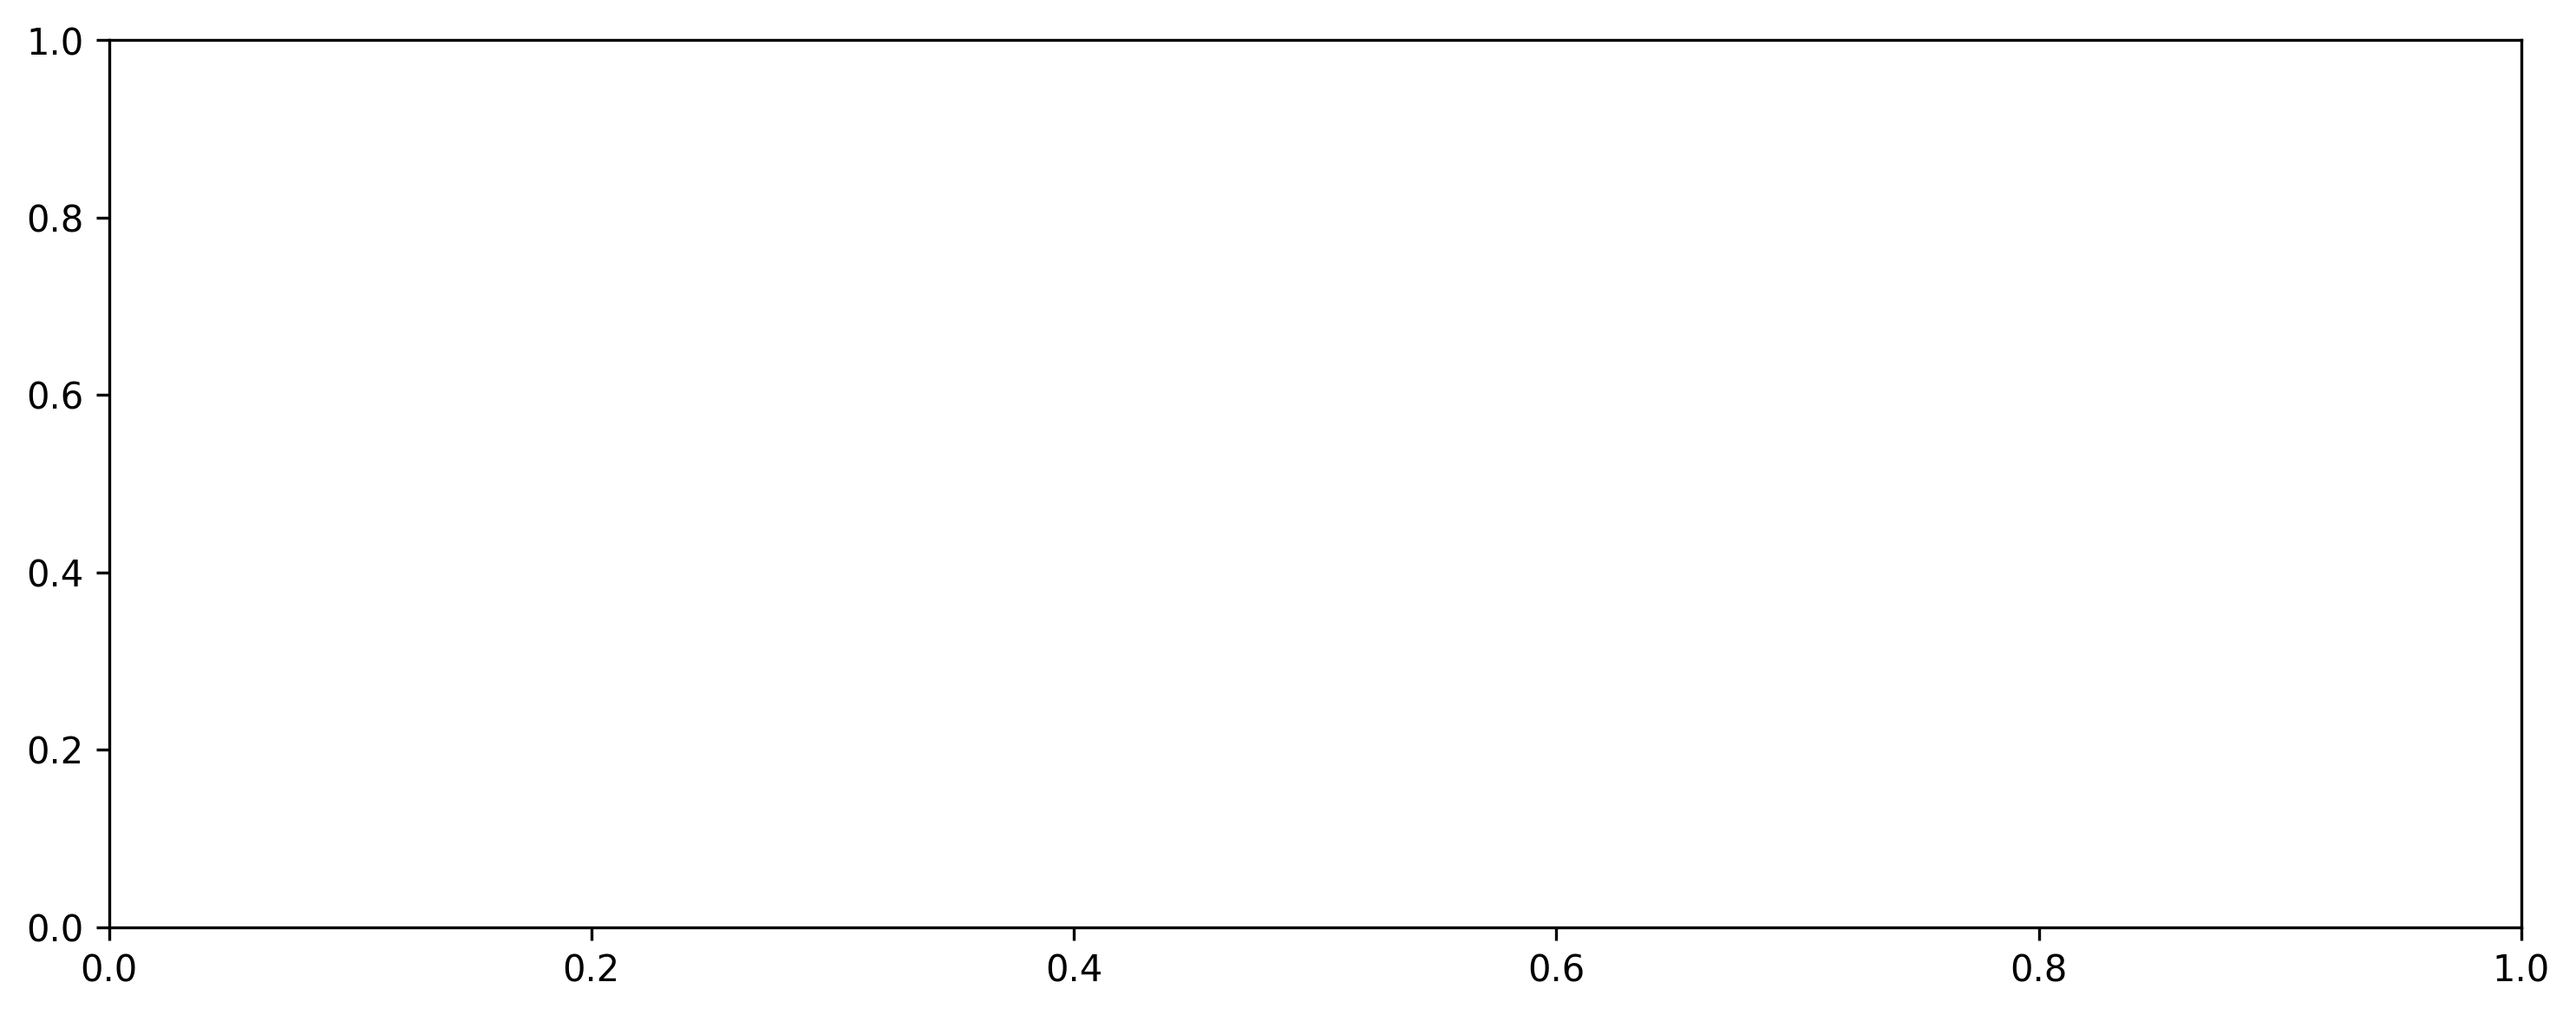

In [6]:
for ds_id,ds_smps in smp_dict.items():
    df = ds_df_dict[ds_id]
    for tgt_id,smps in ds_smps.items():
        print(f"dataset id: {ds_id}  target_id: {tgt_id}")
        for smp in smps:
            frm_id = smp[1]
            nbr_ids = smp[3:]
            # print(f"dataset id: {ds_id}  target_id: {tgt_id}, frm_id: {frm_id}, nbr_id: {nbr_ids}")

            # local_pos,orie = get_loc_pos_orie(df,tgt_id,nbr_ids,frm_id)
            glb_pos,orie = get_glb_pos_orie(df,tgt_id,nbr_ids,frm_id)
            # print(local_pos)
            # print(orie)
            fut_pred = fut_preds_dict[ds_id][tgt_id][frm_id]
            plot_frm(glb_pos,fut_pred,frm_id)
            # print(fut_pred)
            # orie_fut_pred = get_rotated_fut(fut_pred,orie)
            # print(orie_fut_pred)
            # plot_frm(local_pos,orie_fut_pred,frm_id)
            break
        break
    break
            